In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import random
import logging
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from keras import layers, models, Model
from sklearn.metrics import f1_score, recall_score, accuracy_score

import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
import pickle
import os
import librosa
from sklearn.model_selection import train_test_split
from transformers import AutoFeatureExtractor, Wav2Vec2FeatureExtractor, TFWav2Vec2Model, Wav2Vec2Processor

# Only log error messages
tf.get_logger().setLevel(logging.ERROR)
# Set random seed
tf.keras.utils.set_random_seed(42)

In [ ]:
real_audio = "/content/drive/MyDrive/DEMONSTRATION/linus-original-DEMO.mp3"
fake_audio = "/content/drive/MyDrive/DEMONSTRATION/linus-to-musk-DEMO.mp3"

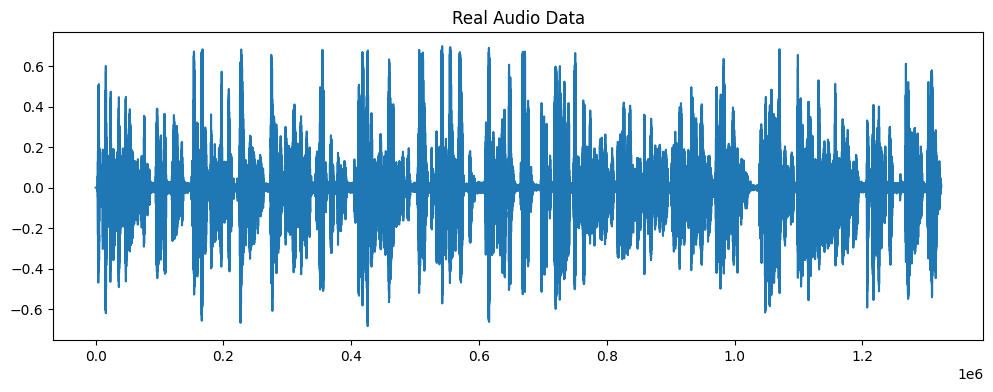

In [ ]:
real_ad, real_sr = librosa.load(real_audio)
plt.figure(figsize=(12, 4))
plt.plot(real_ad)
plt.title("Real Audio Data")
plt.show()

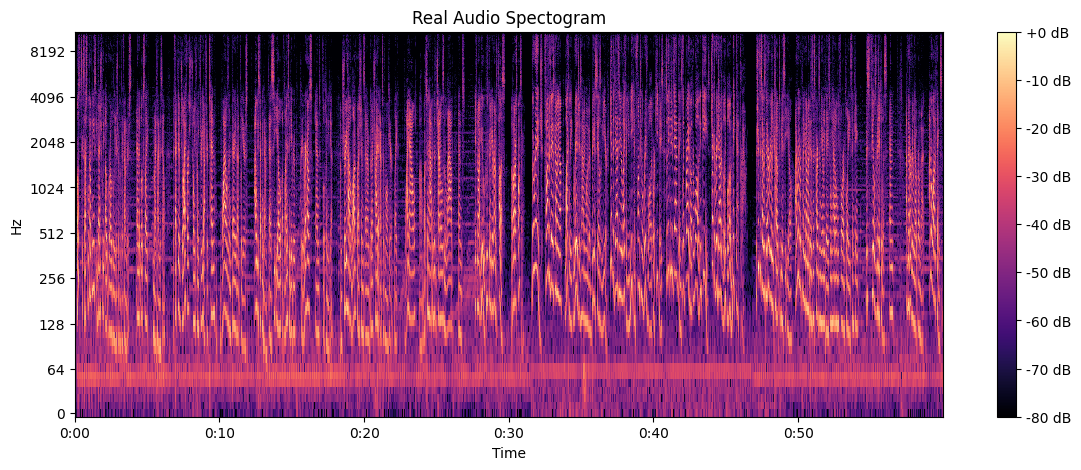

In [ ]:
real_spec = np.abs(librosa.stft(real_ad))
real_spec = librosa.amplitude_to_db(real_spec, ref=np.max)

plt.figure(figsize=(14, 5))
librosa.display.specshow(real_spec, sr=real_sr, x_axis="time", y_axis="log")
plt.colorbar(format="%+2.0f dB")
plt.title("Real Audio Spectogram")
plt.show()

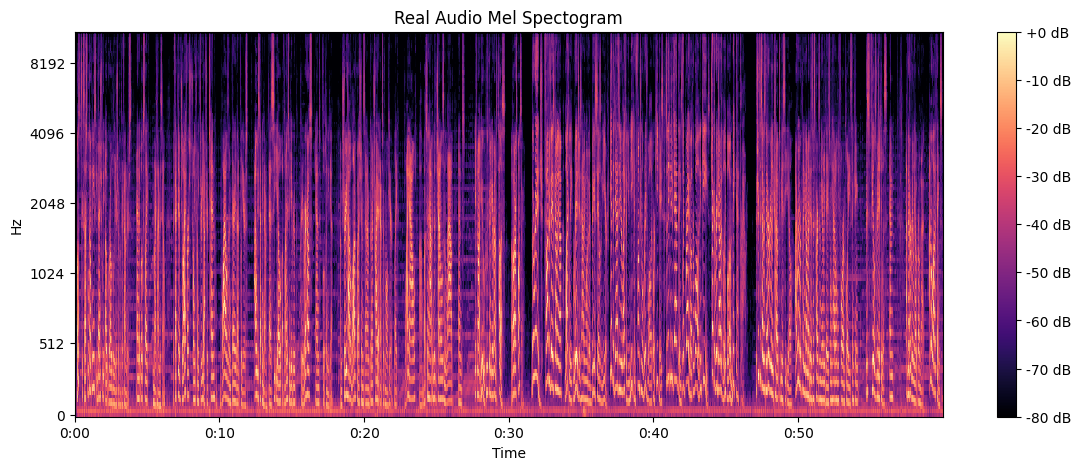

In [ ]:
real_mel_spect = librosa.feature.melspectrogram(y=real_ad, sr=real_sr)
real_mel_spect = librosa.power_to_db(real_mel_spect, ref=np.max)

plt.figure(figsize=(14, 5))
librosa.display.specshow(real_mel_spect, y_axis="mel", x_axis="time")
plt.title("Real Audio Mel Spectogram")
plt.colorbar(format="%+2.0f dB")
plt.show()

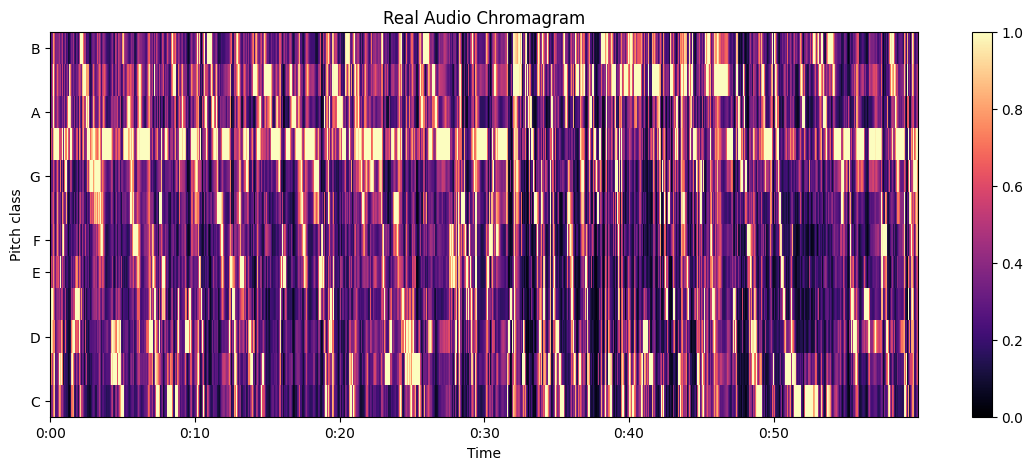

In [ ]:
real_chroma = librosa.feature.chroma_cqt(y=real_ad, sr=real_sr, bins_per_octave=36)

plt.figure(figsize=(14, 5))
librosa.display.specshow(real_chroma, sr=real_sr, x_axis="time", y_axis="chroma", vmin=0, vmax=1)
plt.colorbar()
plt.title("Real Audio Chromagram")
plt.show()


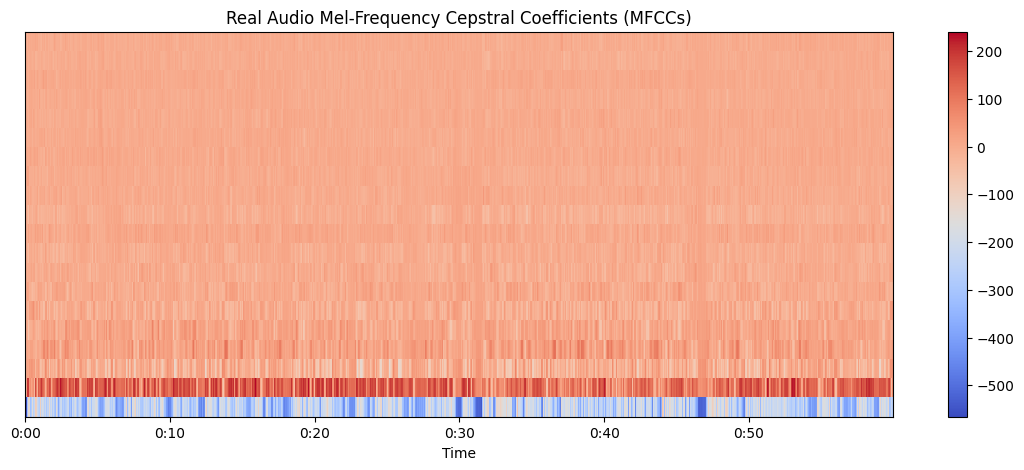

In [ ]:
real_mfccs = librosa.feature.mfcc(y=real_ad, sr=real_sr)

plt.figure(figsize=(14, 5))
librosa.display.specshow(real_mfccs, sr=real_sr, x_axis="time")
plt.colorbar()
plt.title("Real Audio Mel-Frequency Cepstral Coefficients (MFCCs)")
plt.show()

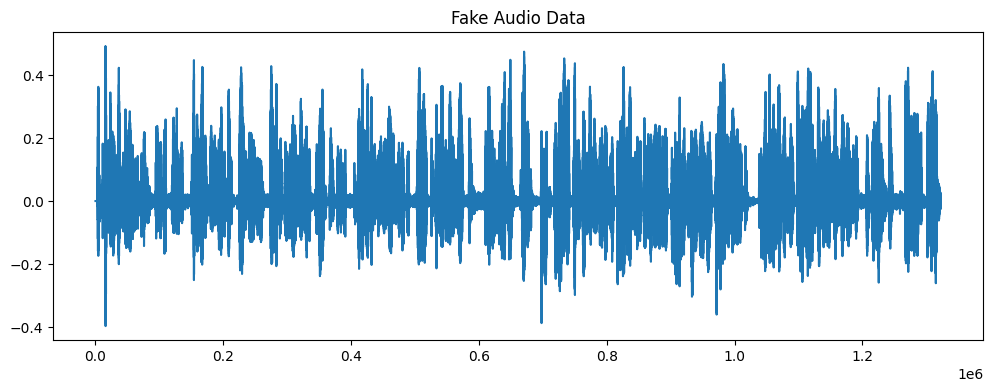

In [ ]:
fake_ad, fake_sr = librosa.load(fake_audio)
plt.figure(figsize=(12, 4))
plt.plot(fake_ad)
plt.title("Fake Audio Data")
plt.show()

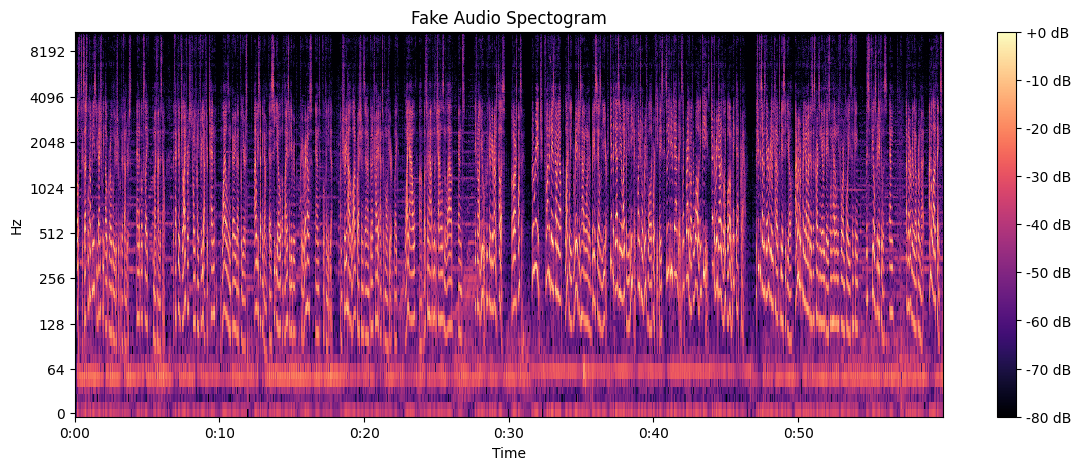

In [ ]:
fake_spec = np.abs(librosa.stft(fake_ad))
fake_spec = librosa.amplitude_to_db(fake_spec, ref=np.max)

plt.figure(figsize=(14, 5))
librosa.display.specshow(fake_spec, sr=fake_sr, x_axis="time", y_axis="log")
plt.colorbar(format="%+2.0f dB")
plt.title("Fake Audio Spectogram")
plt.show()

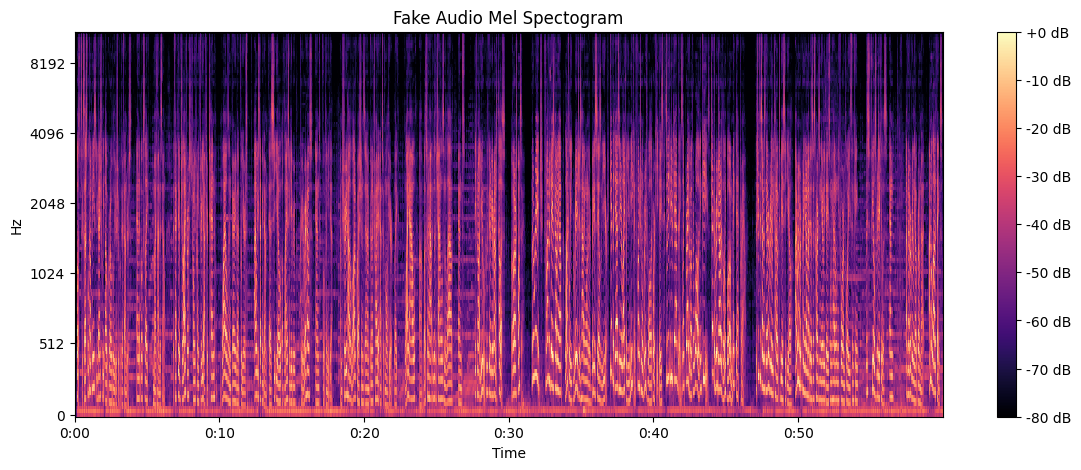

In [ ]:
fake_mel_spect = librosa.feature.melspectrogram(y=fake_ad, sr=fake_sr)
fake_mel_spect = librosa.power_to_db(fake_mel_spect, ref=np.max)

plt.figure(figsize=(14, 5))
librosa.display.specshow(fake_mel_spect, y_axis="mel", x_axis="time")
plt.title("Fake Audio Mel Spectogram")
plt.colorbar(format="%+2.0f dB")
plt.show()

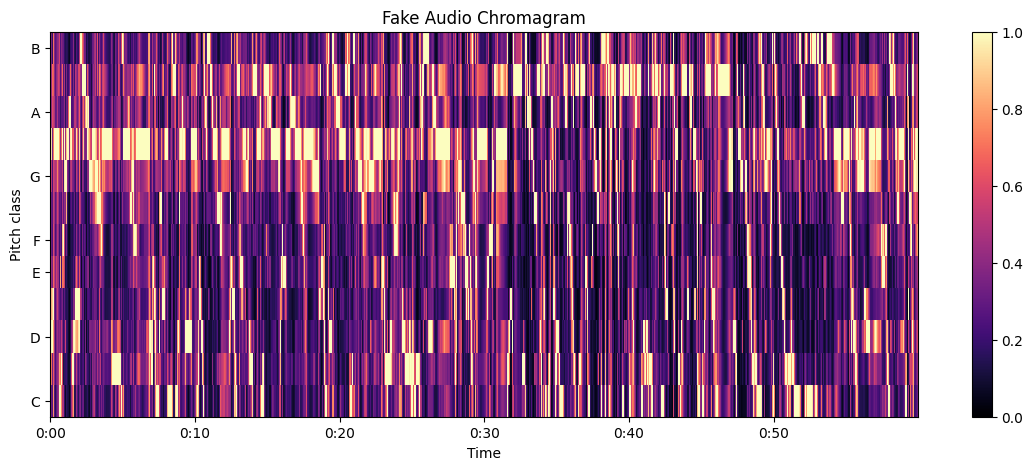

In [ ]:
fake_chroma = librosa.feature.chroma_cqt(y=fake_ad, sr=fake_sr, bins_per_octave=36)

plt.figure(figsize=(14, 5))
librosa.display.specshow(fake_chroma, sr=fake_sr, x_axis="time", y_axis="chroma", vmin=0, vmax=1)
plt.colorbar()
plt.title("Fake Audio Chromagram")
plt.show()

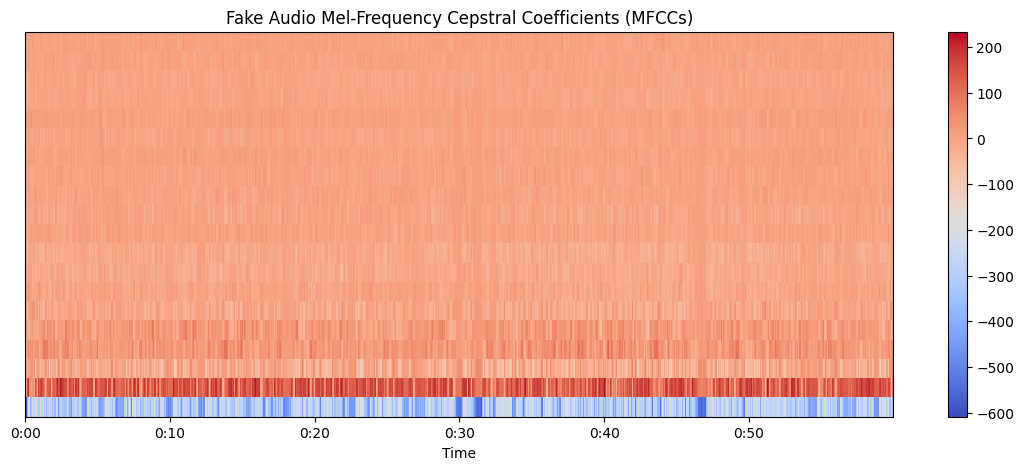

In [ ]:
fake_mfccs = librosa.feature.mfcc(y=fake_ad, sr=fake_sr)

plt.figure(figsize=(14, 5))
librosa.display.specshow(fake_mfccs, sr=fake_sr, x_axis="time")
plt.colorbar()
plt.title("Fake Audio Mel-Frequency Cepstral Coefficients (MFCCs)")
plt.show()

In [ ]:
# Maximum duration of the input audio file we feed to our Wav2Vec 2.0 model.
MAX_DURATION = 5  # Change to 30 seconds

# Sampling rate is the number of samples of audio recorded every second
SAMPLING_RATE = 16000
BATCH_SIZE = 8  # Batch-size for training and evaluating our model.
NUM_CLASSES = 2  # Number of classes our dataset will have (2 in our case).
HIDDEN_DIM = 768  # Dimension of our model output (768 in case of Wav2Vec 2.0 - Base).
MAX_SEQ_LENGTH = MAX_DURATION * SAMPLING_RATE  # Maximum length of the input audio file.

# Wav2Vec 2.0 results in an output frequency with a stride of about 20ms.
MAX_FRAMES = 249 # Adjust for 30 seconds
MAX_EPOCHS = 10  # Maximum number of training epochs.
SEED = 42
MODEL_CHECKPOINT = "facebook/wav2vec2-base"  # Name of pretrained model from Hugging Face Model Hu

FAKE = "/content/drive/MyDrive/audio/FAKE"
REAL = "/content/drive/MyDrive/audio/REAL"

feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/wav2vec2-base")  #retrieve feature extractor



In [ ]:
def load_audio_files_and_labels(fake_folder, real_folder):
    audio_data = []
    labels = []

    # Load fake audio files
    for filename in os.listdir(fake_folder):
        file_path = os.path.join(fake_folder, filename)
        audio, sr = librosa.load(file_path, sr=16000, duration=MAX_DURATION)  # Load 30 seconds
        audio_data.append(audio)
        labels.append(1)

    # Load real audio files
    for filename in os.listdir(real_folder):
        file_path = os.path.join(real_folder, filename)
        audio, sr = librosa.load(file_path, sr=16000, duration=MAX_DURATION)  # Load 30 seconds
        audio_data.append(audio)
        labels.append(0)

    return audio_data, np.array(labels)

def extract_features(audio_data):
    features = []
    for audio in audio_data:
        inputs = feature_extractor(audio, sampling_rate=16000, return_tensors="np", padding=True, truncation=True, max_length=MAX_SEQ_LENGTH)
        features.append(inputs.input_values)
    return np.concatenate(features, axis=0)


In [ ]:
audio_data, labels = load_audio_files_and_labels(FAKE,REAL)
features = extract_features(audio_data)
print(features.shape)


(64, 80000)


In [ ]:
X_tr, X_te, y_tr, y_te = train_test_split(features, labels, test_size=0.2, stratify=labels, random_state=SEED)

In [ ]:
def mean_pool(hidden_states, feature_lengths, batch_size):
    attenion_mask = tf.sequence_mask(
        feature_lengths, maxlen=MAX_FRAMES, dtype=tf.dtypes.int64
    )
    padding_mask = tf.cast(
        tf.reverse(tf.cumsum(tf.reverse(attenion_mask, [-1]), -1), [-1]),
        dtype=tf.dtypes.bool,
    )
    hidden_states = tf.where(
        tf.broadcast_to(
            tf.expand_dims(~padding_mask, -1), (batch_size, MAX_FRAMES, HIDDEN_DIM)
        ),
        0.0,
        hidden_states,
    )
    pooled_state = tf.math.reduce_sum(hidden_states, axis=1) / tf.reshape(
        tf.math.reduce_sum(tf.cast(padding_mask, dtype=tf.dtypes.float32), axis=1),
        [-1, 1],
    )
    return pooled_state

class Wav2Vec2_Model(layers.Layer):

    def __init__(self, model_checkpoint, num_classes):
        super().__init__()
        self.wav2vec2 = TFWav2Vec2Model.from_pretrained(
            model_checkpoint, apply_spec_augment=False, from_pt=True
        )
        self.pooling = layers.GlobalAveragePooling1D()
        self.intermediate_layer_dropout = layers.Dropout(0.5)
        self.final_layer = layers.Dense(num_classes, activation="softmax")

    def call(self, inputs):
        hidden_states = self.wav2vec2(inputs["input_values"])[0]
        batch_size = tf.shape(hidden_states)[0]

        if tf.is_tensor(inputs["attention_mask"]):
            audio_lengths = tf.cumsum(inputs["attention_mask"], -1)[:, -1]
            feature_lengths = self.wav2vec2.wav2vec2._get_feat_extract_output_lengths(
                audio_lengths
            )
            pooled_state = mean_pool(hidden_states, feature_lengths, batch_size)
        else:
            pooled_state = self.pooling(hidden_states)

        intermediate_state = self.intermediate_layer_dropout(pooled_state)
        final_state = self.final_layer(intermediate_state)

        return final_state

# Rebuild the model to apply the mixed precision policy
def build_model():
    inputs = {
        "input_values": tf.keras.Input(shape=(MAX_SEQ_LENGTH,), dtype="float32"),
        "attention_mask": tf.keras.Input(shape=(MAX_SEQ_LENGTH,), dtype="int32"),
    }
    wav2vec2_model = Wav2Vec2_Model(MODEL_CHECKPOINT, NUM_CLASSES)(
        inputs
    )
    model = tf.keras.Model(inputs, wav2vec2_model)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])
    return model

model = build_model()

/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:311: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(

TFWav2Vec2Model has backpropagation operations that are NOT supported on CPU. If you wish to train/fine-tune this model, you need a GPU or a TPU
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFWav2Vec2Model: ['quantizer.weight_proj.bias', 'project_q.bias', 'project_q.weight', 'quantizer.weight_proj.weight', 'project_hid.bias', 'quantizer.codevectors', 'project_hid.weight']
- This IS expected if you are initializing TFWav2Vec2Model from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a Bert

In [ ]:
inputs = tf.data.Dataset.from_tensor_slices(({"input_values": X_tr, "attention_mask": np.ones_like(X_tr)}, y_tr)).batch(BATCH_SIZE)
val_data = tf.data.Dataset.from_tensor_slices(({"input_values": X_te, "attention_mask": np.ones_like(X_te)}, y_te)).batch(BATCH_SIZE)

# Training
history = model.fit(
    inputs,
    validation_data=val_data,
    batch_size=BATCH_SIZE,

    epochs=MAX_EPOCHS
)


Epoch 1/10
7/7 [==============================] - 54s 1s/step - loss: 0.5147 - accuracy: 0.8039 - val_loss: 0.4711 - val_accuracy: 0.8462
Epoch 2/10
7/7 [==============================] - 5s 733ms/step - loss: 0.3472 - accuracy: 0.8824 - val_loss: 0.5187 - val_accuracy: 0.8462
Epoch 3/10
7/7 [==============================] - 5s 728ms/step - loss: 0.3368 - accuracy: 0.8824 - val_loss: 0.4688 - val_accuracy: 0.8462
Epoch 4/10
7/7 [==============================] - 5s 759ms/step - loss: 0.2849 - accuracy: 0.8824 - val_loss: 0.3877 - val_accuracy: 0.8462
Epoch 5/10
7/7 [==============================] - 5s 733ms/step - loss: 0.2298 - accuracy: 0.9020 - val_loss: 0.3393 - val_accuracy: 0.8462
Epoch 6/10
7/7 [==============================] - 5s 748ms/step - loss: 0.1859 - accuracy: 0.9216 - val_loss: 0.2980 - val_accuracy: 0.8462
Epoch 7/10
7/7 [==============================] - 5s 741ms/step - loss: 0.1459 - accuracy: 0.9608 - val_loss: 0.2862 - val_accuracy: 0.8462
Epoch 8/10
7/7 [======

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Get training accuracy list
training_accuracy = history.history['accuracy']
print("Training Accuracy List: ", training_accuracy)


# Get predictions
y_pred_probs = model.predict(
    {"input_values": X_te, "attention_mask": np.ones_like(X_te)},
    batch_size=BATCH_SIZE
)

# Convert predicted probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_te, y_pred)

# Calculate precision, recall, and F1-score
precision = precision_score(y_te, y_pred, average='binary')
f1 = f1_score(y_te, y_pred, average='binary')
recal= recall_score(y_te, y_pred, average='binary')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"F1-score: {f1}")

Training Accuracy List:  [0.8039215803146362, 0.8823529481887817, 0.8823529481887817, 0.8823529481887817, 0.9019607901573181, 0.9215686321258545, 0.9607843160629272, 0.9803921580314636, 0.9803921580314636, 0.9803921580314636]
2/2 [==============================] - 4s 161ms/step
Accuracy: 0.9230769230769231
Precision: 0.9166666666666666
F1-score: 0.9565217391304348


In [ ]:
import numpy as np
import pandas as pd
import os
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import IPython
import json
from scipy.io import wavfile
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, recall_score
from sklearn.preprocessing import RobustScaler, PowerTransformer, StandardScaler, MinMaxScaler, OneHotEncoder, FunctionTransformer, LabelBinarizer
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow import keras
from keras import Model, layers, models, callbacks
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Reshape, MaxPooling2D, Dropout, Conv2D, MaxPool2D, Flatten, Input, LSTM
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras import metrics

In [ ]:
real_path = "/content/drive/MyDrive/audio/REAL"
fake_path = "/content/drive/MyDrive/audio/FAKE"

csv_path = "/content/drive/MyDrive/DATASET-balanced.csv"


df = pd.read_csv(csv_path)
df['LABEL'] = df['LABEL'].apply(lambda x: 1 if x == 'REAL' else 0)
df.head()

chroma_stft       rms  spectral_centroid  spectral_bandwidth      rolloff  \
0     0.338055  0.027948        2842.948867         4322.916759  6570.586186   
1     0.443766  0.037838        2336.129597         3445.777044  3764.949874   
2     0.302528  0.056578        2692.988386         2861.133180  4716.610271   
3     0.319933  0.031504        2241.665382         3503.766175  3798.641521   
4     0.420055  0.016158        2526.069123         3102.659519  5025.077899   

   zero_crossing_rate       mfcc1       mfcc2      mfcc3      mfcc4  ...  \
0            0.041050 -462.169586   90.311272  19.073769  24.046888  ...   
1            0.047730 -409.413422  120.348808  -7.161531   5.114784  ...   
2            0.080342 -318.996033  120.490273 -24.625771  23.891073  ...   
3            0.047180 -404.636749  136.320908   2.308172  -3.907071  ...   
4            0.051905 -410.497925  152.731400 -18.266771  51.993462  ...   

     mfcc12    mfcc13    mfcc14    mfcc15    mfcc16    mfcc17    mfcc18  \
0 -6.686564  0.902086 -7.251551 -1.198342  4.747403 -4.986279  0.953935   
1 -2.131157 -6.876417 -1.359395  0.326401 -5.420016 -2.109968 -1.757634   
2 -5.853725 -3.724773 -6.627182 -5.117002 -6.072106 -0.994653 -1.617120   
3 -1.898315 -2.046493 -7.176277 -3.293508  4.209121  0.121835 -5.407063   
4 -1.952340  0.810868  6.238493  6.555839  7.535542  2.849219  2.616843   

     mfcc19    mfcc20  LABEL  
0 -5.013138 -6.779060      0  
1 -9.537907 -8.494421      0  
2 -3.922354 -7.033001      0  
3 -3.654926 -3.274857      0  
4 -1.793357 -5.060998      0  

[5 rows x 27 columns]

In [ ]:
def extract_features(audio_path, sr, start_time, duration, label, id, time):
    # Load the audio file
    y, sr = librosa.load(audio_path, sr=sr, offset=start_time, duration=duration)

    # Extract features
    chroma_stft = np.mean(librosa.feature.chroma_stft(y=y, sr=sr), axis=1)
    rms = np.mean(librosa.feature.rms(y=y), axis=1)
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr), axis=1)
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr), axis=1)
    rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr), axis=1)
    zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y=y), axis=1)

    # Extract all 20 MFCCs
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    mfcc_mean = np.mean(mfcc, axis=1)  # Mean of all MFCC coefficients

    # Combine all features into one vector (8 base features + 20 MFCCs)
    features = np.concatenate([
        [np.mean(chroma_stft)], [np.mean(rms)], [np.mean(spectral_centroid)],
        [np.mean(spectral_bandwidth)], [np.mean(rolloff)],
        [np.mean(zero_crossing_rate)], mfcc_mean, [label], [id], [time]
    ])

    return features


In [ ]:
num_seconds = 10
num_features = 29
num_total_segments = 11000
features = np.zeros((1, num_features))

file_index = 0
id = 0

for filename in os.listdir(real_path):
    if filename.endswith(".wav"):
        wav_file_path = os.path.join(real_path, filename)  # Ensure correct path
        duration = librosa.get_duration(filename=wav_file_path)
        max_segments = int(duration // num_seconds)  # Max number of 10-second segments we can extract
        # iterate through each segment
        for i in range(max_segments - 1):
            start_time = i * num_seconds
            for time in range(num_seconds):
                new_features  = extract_features(wav_file_path, 22050, start_time + time, 1, 1, id, time)
                features = np.concatenate((features, new_features.reshape(1, 29)), axis=0)
                file_index += 1
        id += 1


for filename in os.listdir(fake_path):
    if filename.endswith(".wav"):
        wav_file_path = os.path.join(fake_path, filename)  # Ensure correct path
        duration = librosa.get_duration(filename=wav_file_path)
        max_segments = int(duration // num_seconds)  # Max number of 10-second segments we can extract
        # iterate through each segment
        for i in range(max_segments - 1):
            start_time = i * num_seconds
            for time in range(num_seconds):
                new_features  = extract_features(wav_file_path, 22050, start_time + time, 1, 0, id, time)
                features = np.concatenate((features, new_features.reshape(1, 29)), axis=0)
                file_index += 1
        id += 1

<ipython-input-48-caef752310d4>:12: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=wav_file_path)
<ipython-input-48-caef752310d4>:27: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=wav_file_path)


In [ ]:
base_columns = ['chroma_stft', 'rms', 'spectral_centroid', 'spectral_bandwidth',
                'rolloff', 'zero_crossing_rate']
mfcc_columns = [f'mfcc{i+1}' for i in range(20)]
columns = base_columns + mfcc_columns + ['label', 'id', 'time']

df = pd.DataFrame(features, columns=columns)
df.to_csv('10_seconds_full.csv', index=False)


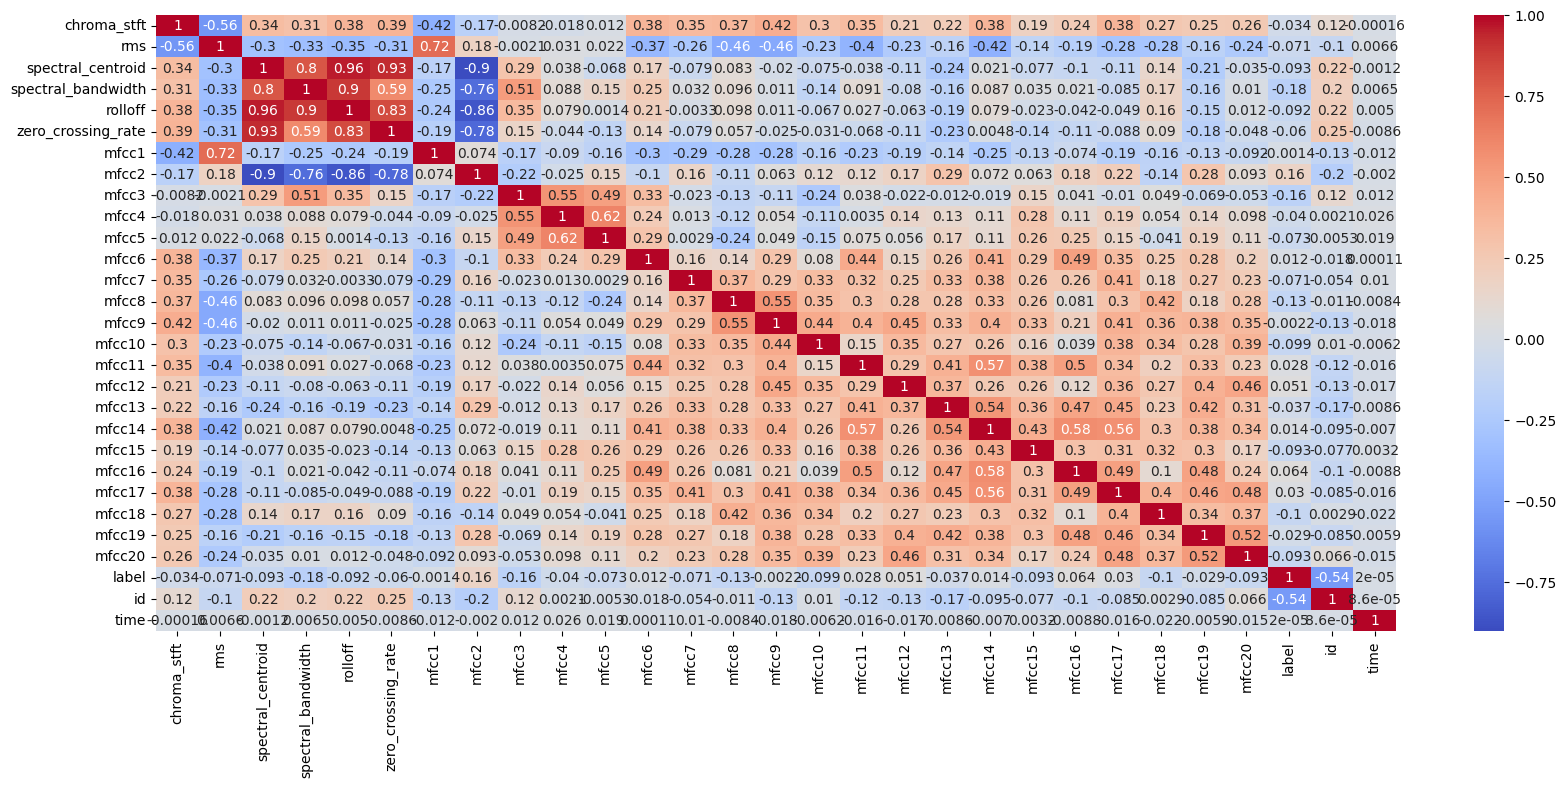

In [ ]:
plt.figure(figsize=(20, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()


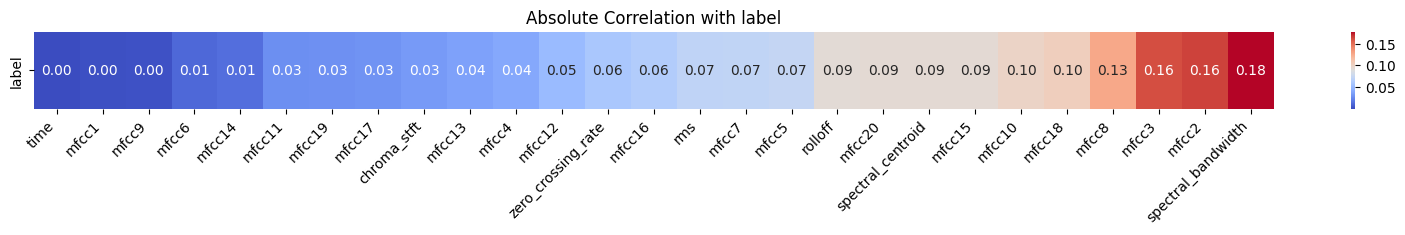

In [ ]:
label_correlation = df.corr()['label'].drop('label').drop('id')
correlation = label_correlation.abs().to_frame().T
correlation = correlation.sort_values(by=correlation.index[0], axis=1, ascending=True)

plt.figure(figsize=(20, 1))
ax = sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Absolute Correlation with label")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show()

<ipython-input-52-b8c377f8d890>:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='LABEL')


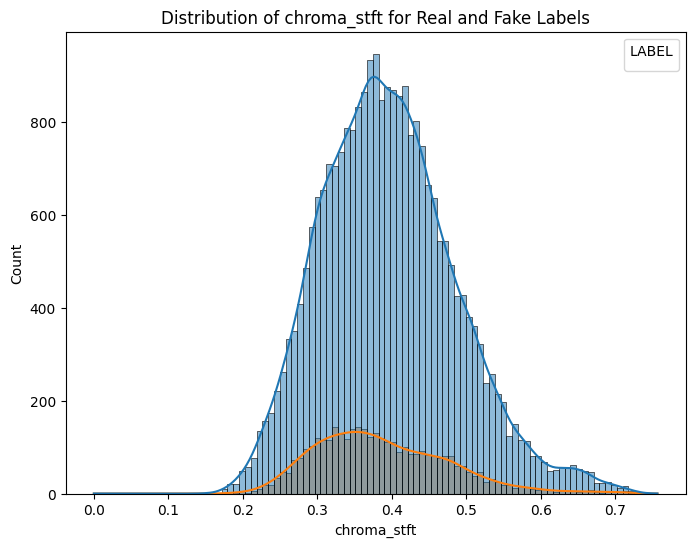

<ipython-input-52-b8c377f8d890>:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='LABEL')


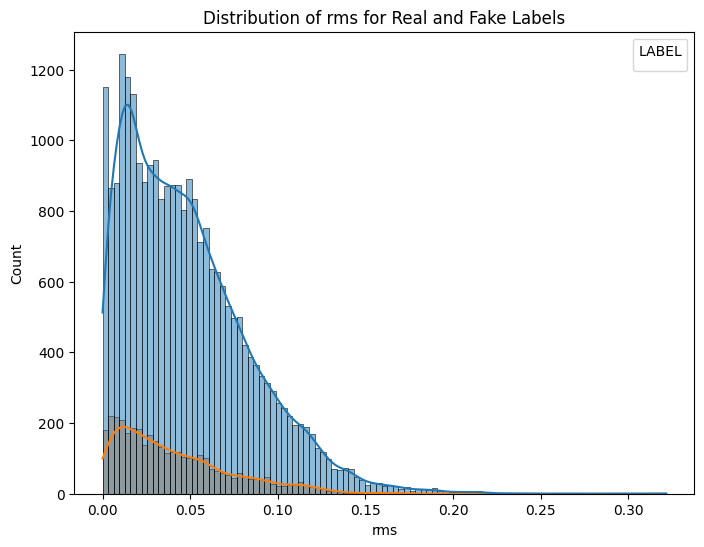

<ipython-input-52-b8c377f8d890>:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='LABEL')


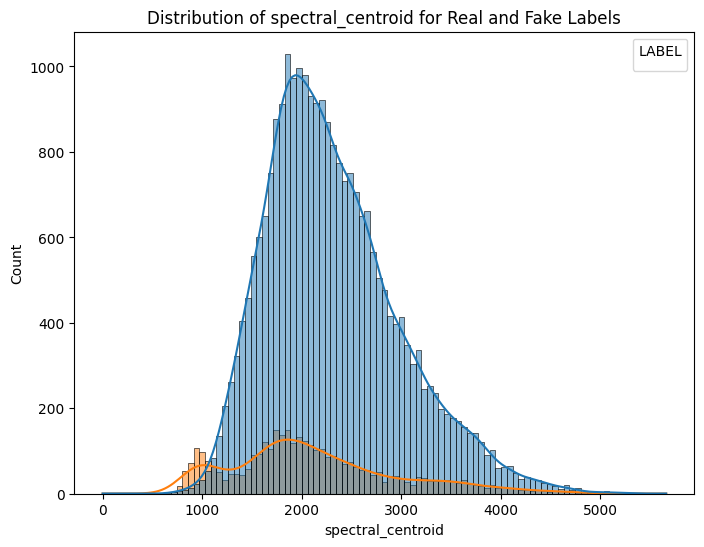

<ipython-input-52-b8c377f8d890>:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='LABEL')


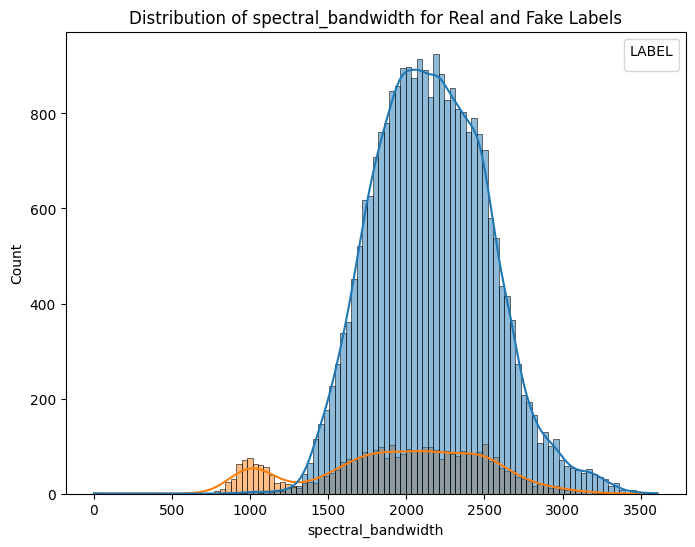

<ipython-input-52-b8c377f8d890>:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='LABEL')


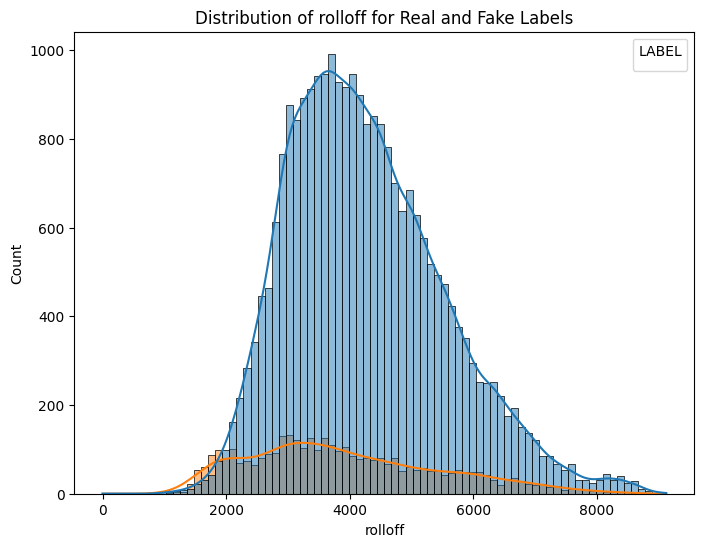

<ipython-input-52-b8c377f8d890>:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='LABEL')


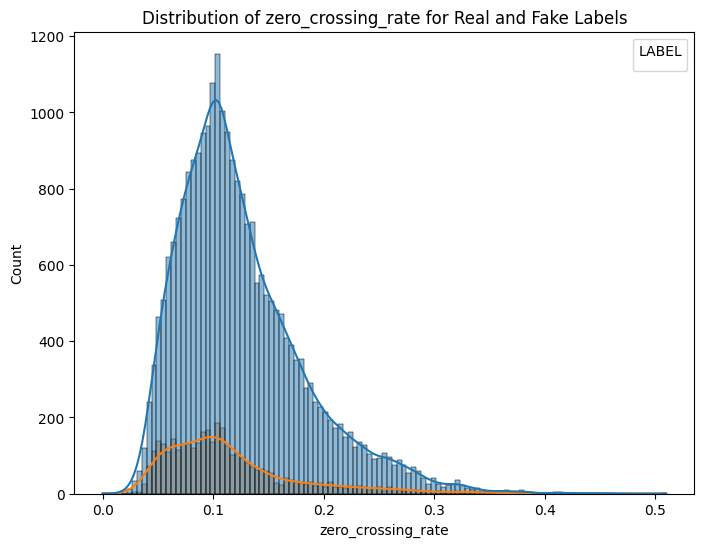

<ipython-input-52-b8c377f8d890>:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='LABEL')


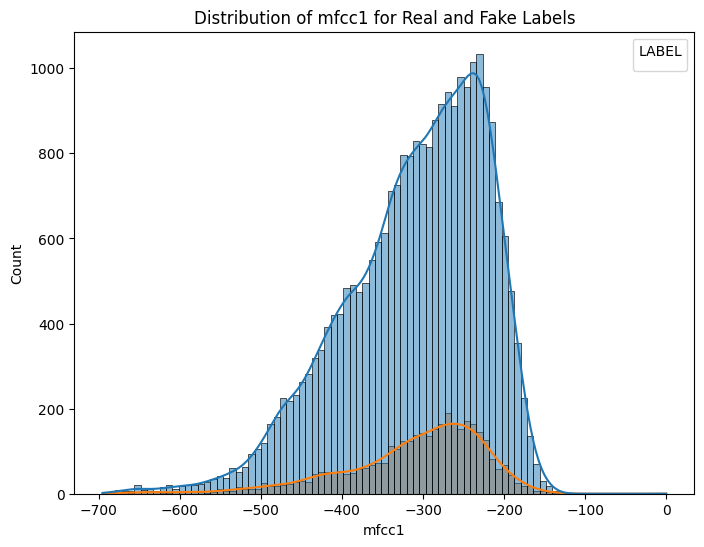

<ipython-input-52-b8c377f8d890>:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='LABEL')


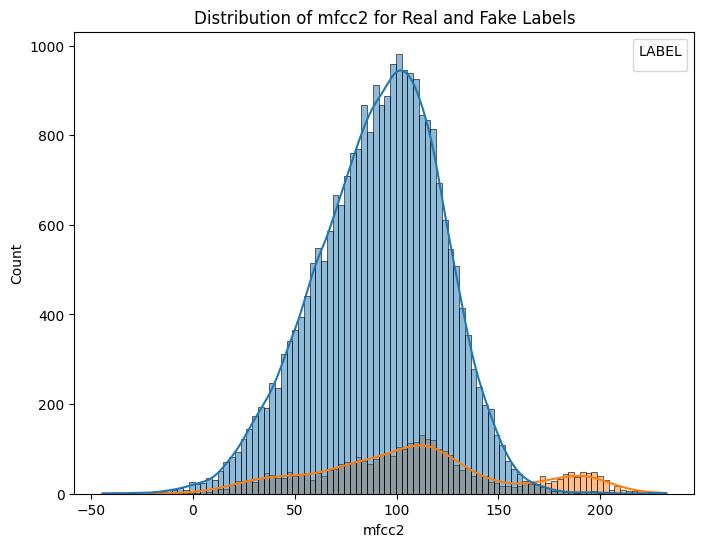

<ipython-input-52-b8c377f8d890>:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='LABEL')


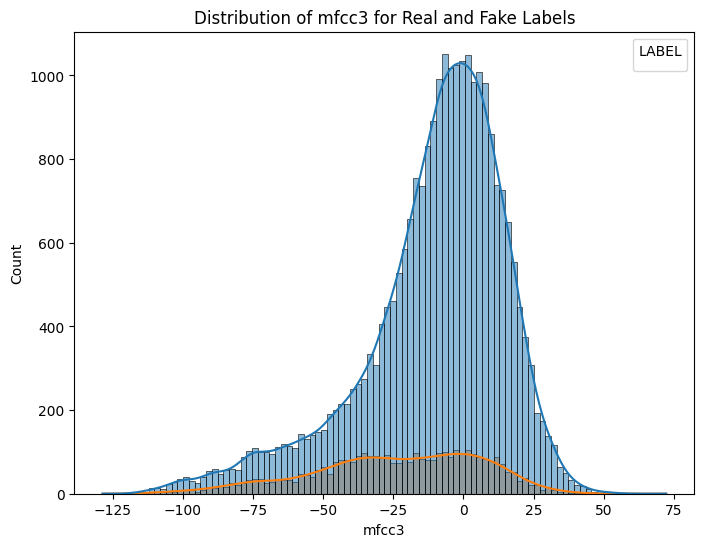

<ipython-input-52-b8c377f8d890>:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='LABEL')


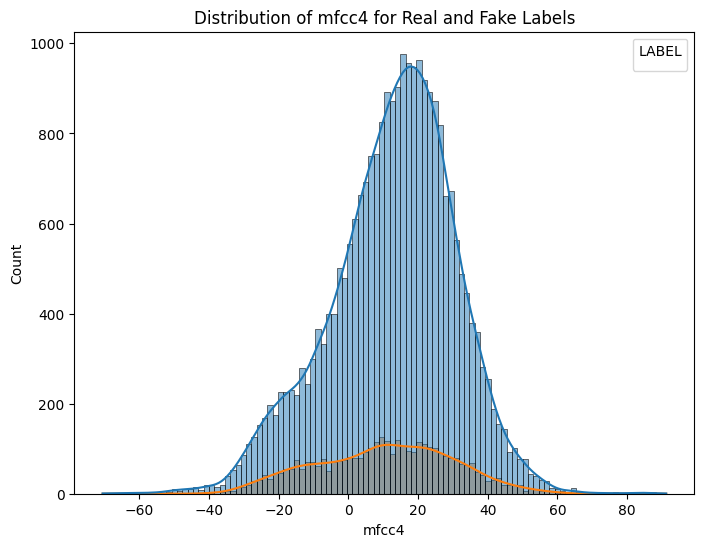

<ipython-input-52-b8c377f8d890>:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='LABEL')


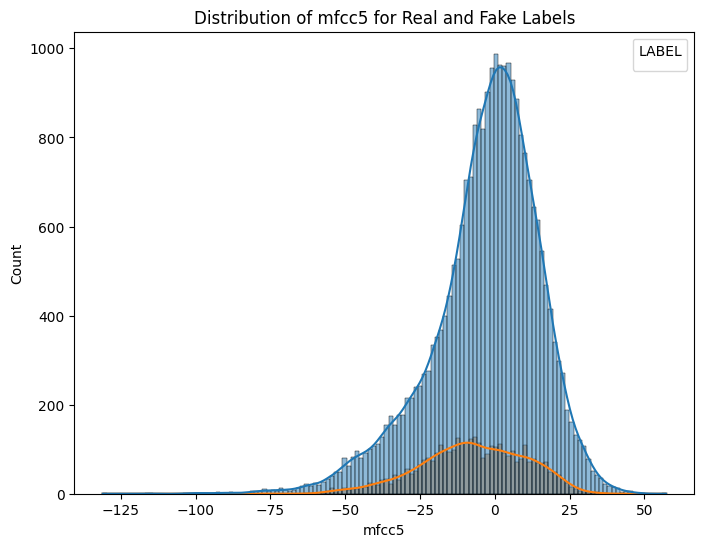

<ipython-input-52-b8c377f8d890>:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='LABEL')


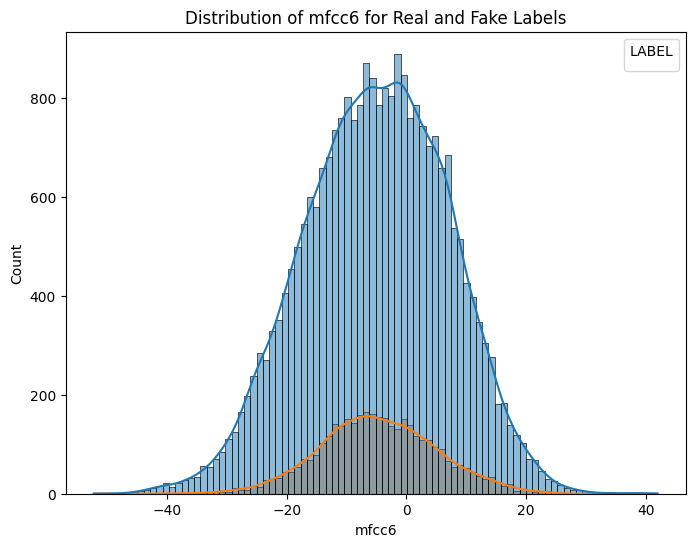

<ipython-input-52-b8c377f8d890>:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='LABEL')


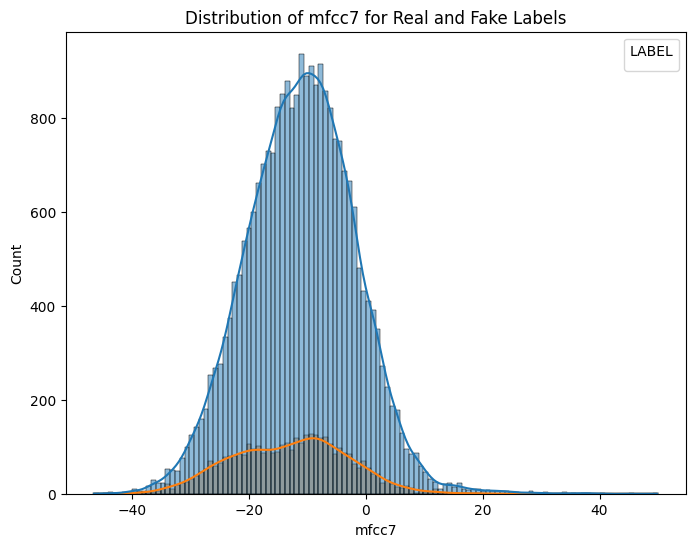

<ipython-input-52-b8c377f8d890>:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='LABEL')


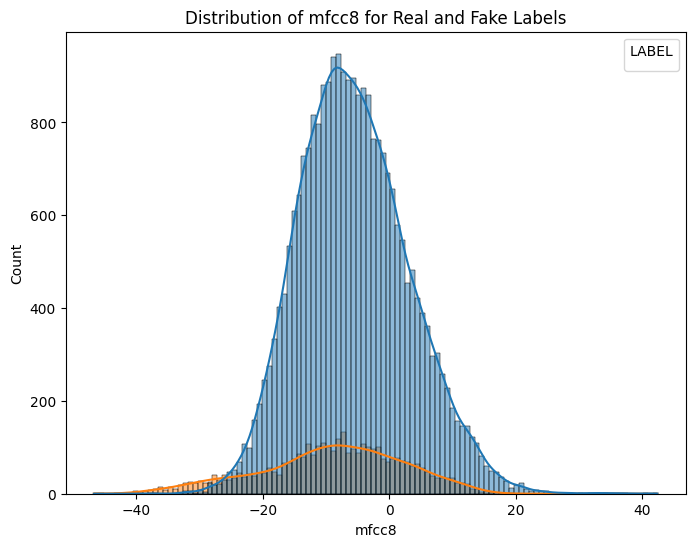

<ipython-input-52-b8c377f8d890>:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='LABEL')


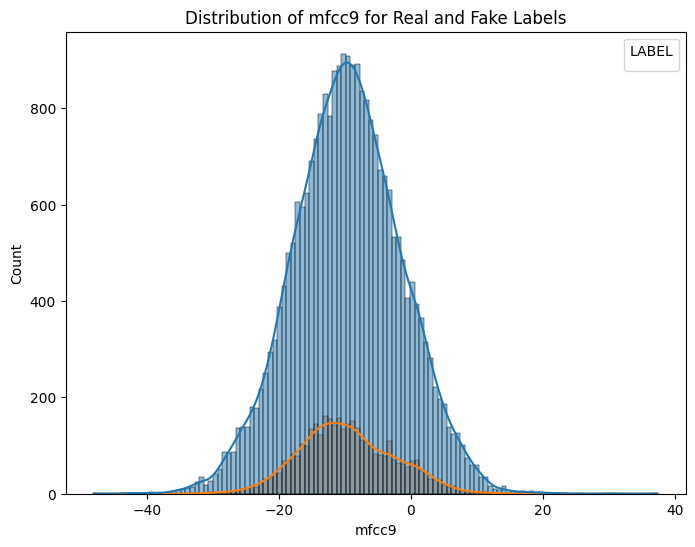

<ipython-input-52-b8c377f8d890>:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='LABEL')


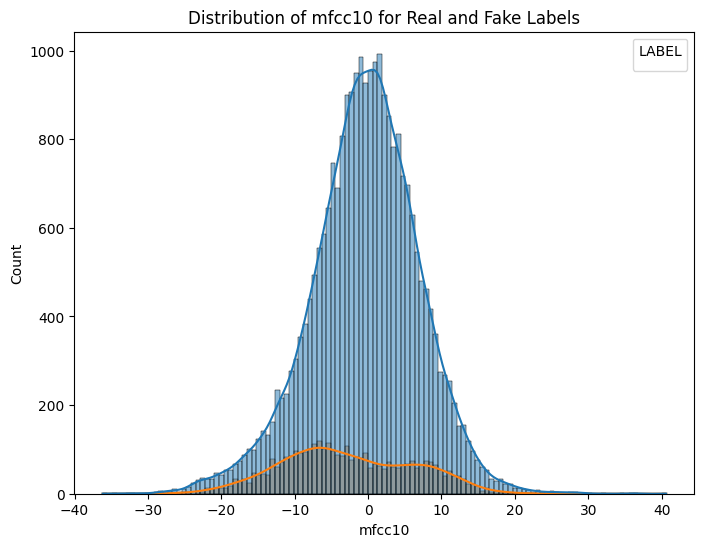

<ipython-input-52-b8c377f8d890>:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='LABEL')


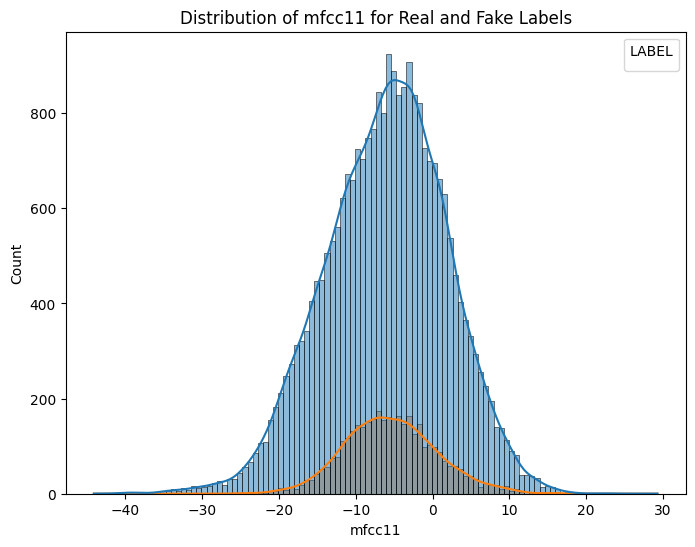

<ipython-input-52-b8c377f8d890>:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='LABEL')


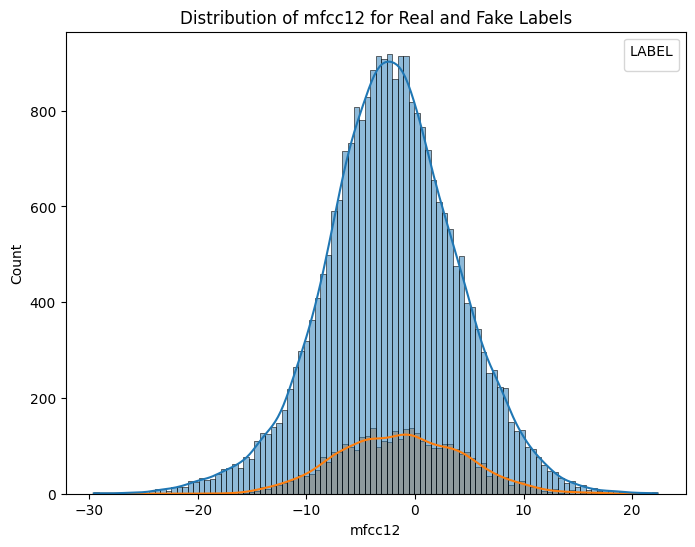

<ipython-input-52-b8c377f8d890>:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='LABEL')


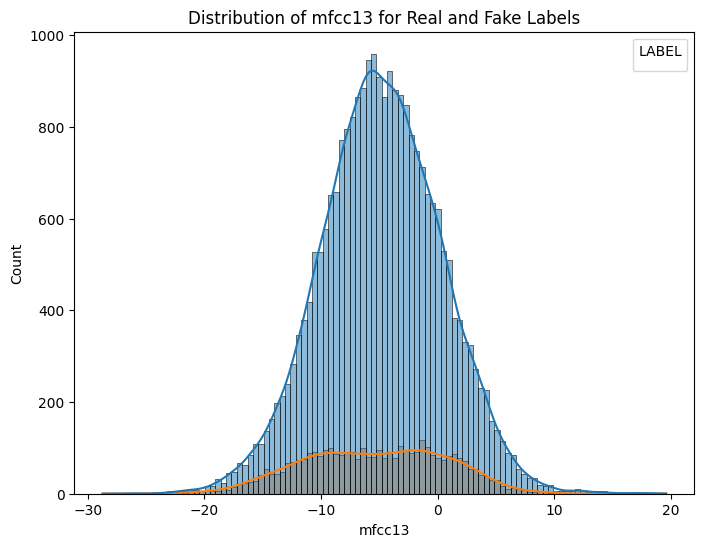

<ipython-input-52-b8c377f8d890>:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='LABEL')


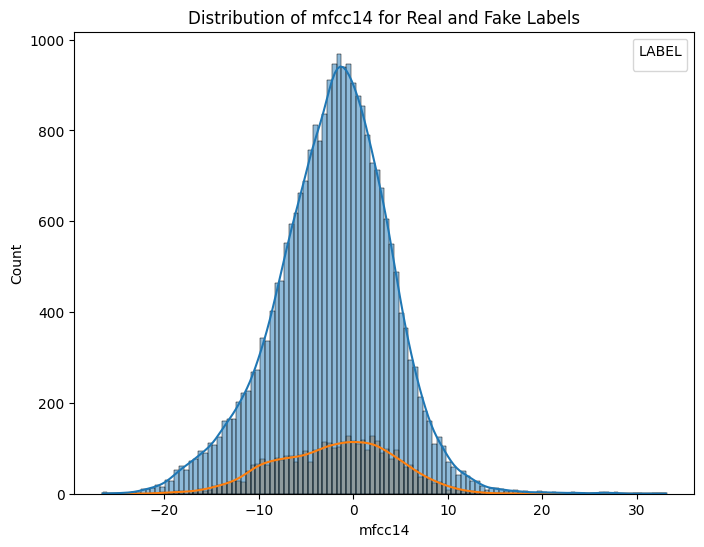

<ipython-input-52-b8c377f8d890>:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='LABEL')


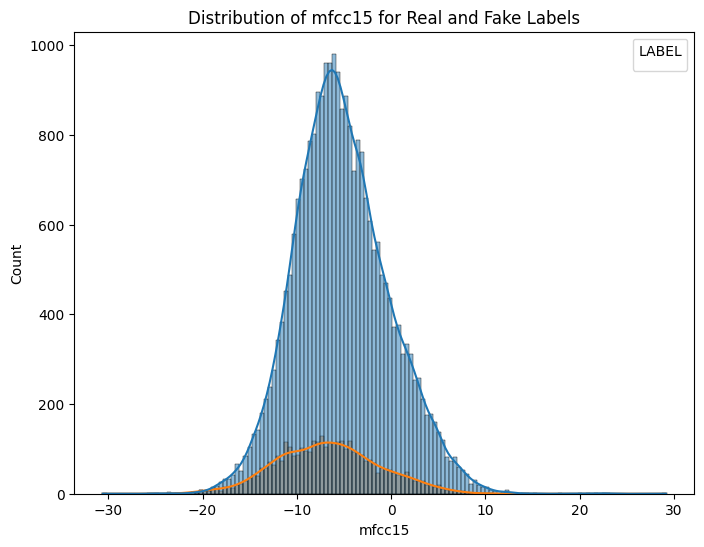

<ipython-input-52-b8c377f8d890>:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='LABEL')


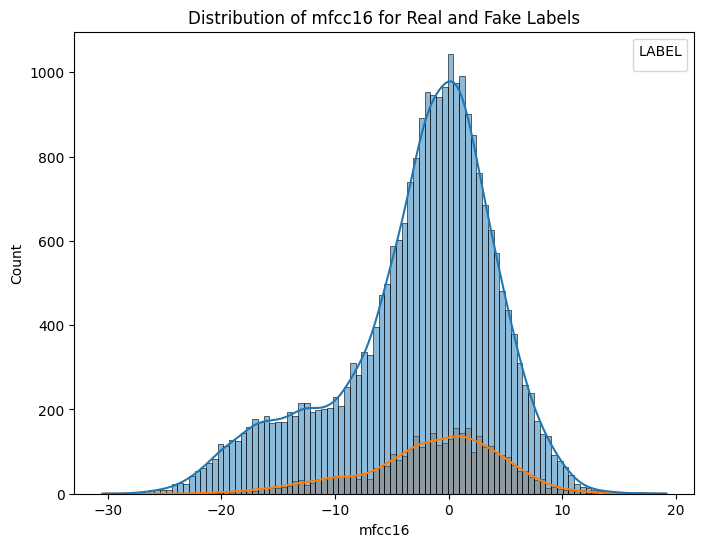

<ipython-input-52-b8c377f8d890>:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='LABEL')


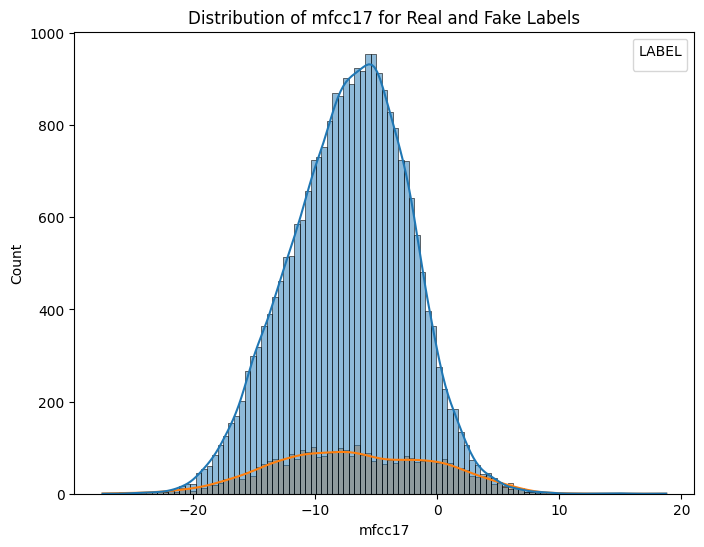

<ipython-input-52-b8c377f8d890>:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='LABEL')


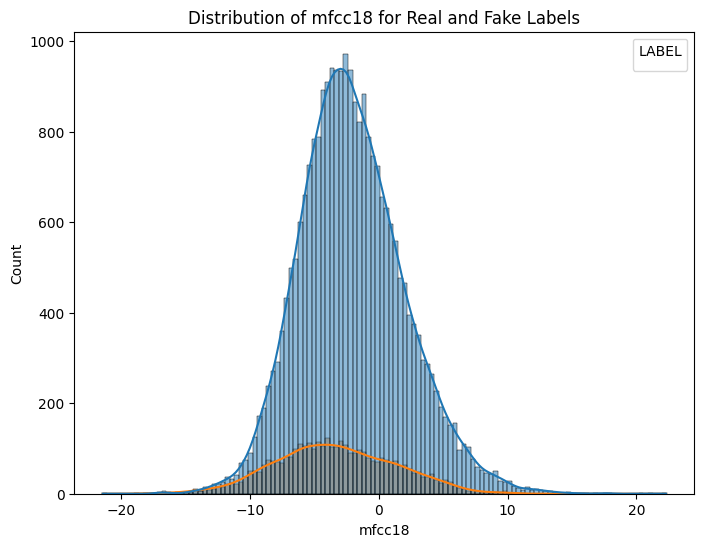

<ipython-input-52-b8c377f8d890>:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='LABEL')


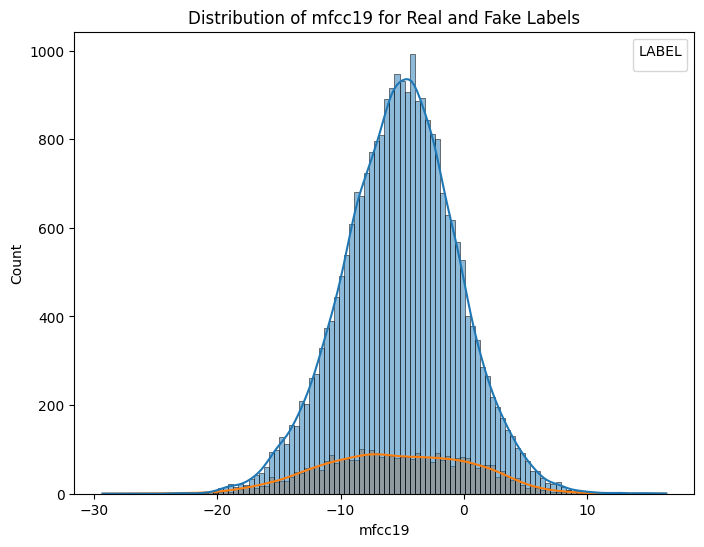

<ipython-input-52-b8c377f8d890>:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='LABEL')


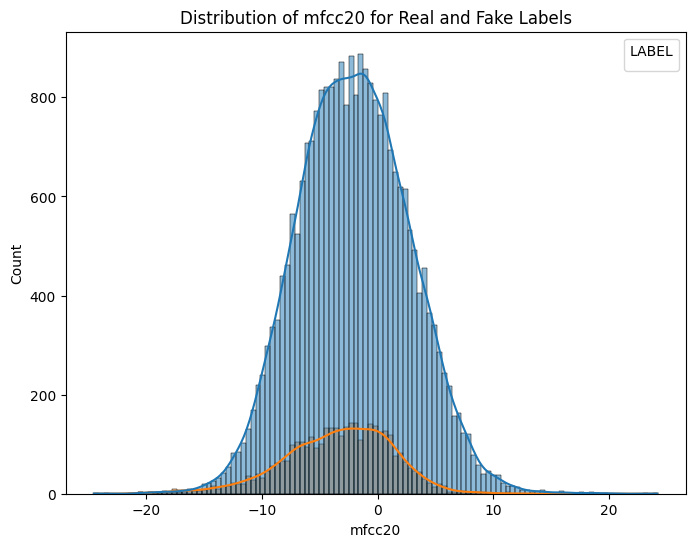

In [ ]:
for var in columns:
    if var == 'label' or var == 'id' or var == 'time':
        continue
    plt.figure(figsize=(8, 6))  # Adjust figure size if needed
    sns.histplot(data=df, x=var, hue='label', kde=True, stat='count', common_norm=False)
    plt.xlabel(var)
    plt.ylabel('Count')
    plt.title(f'Distribution of {var} for Real and Fake Labels')
    plt.legend(title='LABEL')
    plt.show()

In [ ]:
df = pd.read_csv(csv_path)
df['LABEL'] = df['LABEL'].apply(lambda x: 1 if x == 'REAL' else 0)

y = df['LABEL']
X = df.drop(columns=['LABEL'])

seed = 2002513
xtr, xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=seed)


In [ ]:
model = LogisticRegression(max_iter=1000)
model.fit(xtr, ytr)

y_pred = model.predict(xte)
accuracy = accuracy_score(yte, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.81


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
scaler = StandardScaler()
xtr_scaled = scaler.fit_transform(xtr)
xte_scaled = scaler.transform(xte)

model = LogisticRegression(max_iter=1000)
model.fit(xtr_scaled, ytr)
y_pred = model.predict(xte_scaled)
accuracy = accuracy_score(yte, y_pred)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.90


In [ ]:
df = pd.read_csv('10_seconds_full.csv')

y = df['label']
X = df.drop(columns=['label','id', 'time'])

seed = 2002513
xtr, xte, ytr, yte = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed)

scaler = StandardScaler()
xtr_scaled = scaler.fit_transform(xtr)
xte_scaled = scaler.transform(xte)

model = LogisticRegression(max_iter=1000)
model.fit(xtr_scaled, ytr)
y_pred = model.predict(xte_scaled)
accuracy = accuracy_score(yte, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.91


In [ ]:
def sigmoid(X):
    return 1 / (1+np.exp(-X))

def tanh(X):
    return (np.exp(X) - np.exp(-X)) / (np.exp(X) + np.exp(-X))

def softmax(X):
    exp_X = np.exp(X)
    exp_X_sum = np.sum(exp_X, axis=1).reshape(-1, 1)
    exp_X = exp_X / exp_X_sum
    return exp_X

def tanh_derivative(X):
    return 1-(X**2)


In [ ]:
def init_params(input_units, hidden_units, output_units):
    mean = 0
    std = 0.01

    forget_gate_weights = np.random.normal(mean,std,(input_units+hidden_units,hidden_units))
    input_gate_weights_percent  = np.random.normal(mean,std,(input_units+hidden_units,hidden_units))
    input_gate_weights_memory  = np.random.normal(mean,std,(input_units+hidden_units,hidden_units))
    output_gate_weights = np.random.normal(mean,std,(input_units+hidden_units,hidden_units))


    forget_gate_bias = np.random.normal(mean,std,(1, hidden_units))
    input_gate_percent_bias = np.random.normal(mean,std,(1, hidden_units))
    input_gate_memory_bias = np.random.normal(mean,std,(1, hidden_units))
    output_gate_bias = np.random.normal(mean,std,(1, hidden_units))

    hidden_output_weights = np.random.normal(mean,std,(hidden_units,output_units))

    parameters = dict()
    parameters['fgw'] = forget_gate_weights
    parameters['igpw'] = input_gate_weights_percent
    parameters['igmw'] = input_gate_weights_memory
    parameters['ogw'] = output_gate_weights

    parameters['fgb'] = forget_gate_bias
    parameters['igpb'] = input_gate_percent_bias
    parameters['igmb'] = input_gate_memory_bias
    parameters['ogb'] = output_gate_bias

    return parameters

In [ ]:
def lstm_cell(parameters, short_term_matrix, long_term_matrix, input_matrix):
    fgw = parameters['fgw']
    igpw = parameters['igpw']
    igmw = parameters['igmw']
    ogw = parameters['ogw']


    fgb = parameters['fgb']
    igpb = parameters['igpb']
    igmb = parameters['igmb']
    ogb = parameters['ogb']

    # concatenate input and short term memory matrix
    concat_dataset = np.concatenate((short_term_matrix, input_matrix), axis=1)

    # forget gate
    fa = np.matmul(concat_dataset, fgw)
    fa = np.add(fa, fgb)
    forget_gate_output = sigmoid(fa)

    # input gate
    input_potential = np.matmul(concat_dataset, igpw)
    input_potential = np.add(input_potential, igpb)
    input_potential = sigmoid(input_potential)

    input_memory = np.matmul(concat_dataset, igmw)
    input_memory = np.add(input_memory, igmb)
    input_memory = tanh(input_memory)

    input_gate_output = input_potential * input_memory

    # update long term memory
    long_term_memory = np.multiply(long_term_matrix, forget_gate_output)
    long_term_memory = np.add(long_term_memory, input_gate_output)

    # output gate
    output_percent = np.matmul(concat_dataset, ogw)
    output_percent = np.add(output_percent, ogb)
    output_percent = sigmoid(output_percent)

    output_potential = tanh(long_term_memory)

    # update short term memory
    short_term_memory = np.multiply(output_percent, output_potential)

    # return long and short term memory
    return long_term_memory, short_term_memory


In [ ]:
input_units = 26
hidden_units = 128
output_units = 1

# Initialize parameters
parameters = init_params(input_units, hidden_units, output_units)

# Define input data and memory matrices
input_matrix = np.random.randn(20, input_units)  # Simulated input
short_term_matrix = np.random.randn(20, hidden_units)
long_term_matrix = np.random.randn(20, hidden_units)

# Run LSTM cell
new_long_term_memory, new_short_term_memory = lstm_cell(parameters, short_term_matrix, long_term_matrix, input_matrix)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Generate sample predictions
y_true = np.random.randint(0, 2, size=(20,))
y_pred = np.random.randint(0, 2, size=(20,))
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Display results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.5500
Precision: 0.4545
F1 Score: 0.5263


In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/index.html

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.model_selection import train_test_split


class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {"input_values": torch.tensor(self.features[idx], dtype=torch.float),
                "labels": torch.tensor(self.labels[idx], dtype=torch.long)}
        return item

# Assuming X and y are your original features and labels
# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=seed)  # Split 70% for train, 30% for val+test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=seed) # Further split the 30% into 15% val, 15% test


X_train = X_train if isinstance(X_train, np.ndarray) else X_train.values
X_val = X_val if isinstance(X_val, np.ndarray) else X_val.values # Now X_val is defined
X_test = X_test if isinstance(X_test, np.ndarray) else X_test.values
y_train = np.array(y_train)
y_vals = np.array(y_val) # y_vals is now defined as y_val
y_test = np.array(y_test)

train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_vals)
test_dataset = CustomDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

class SimpleTransformer(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads, hidden_dim, output_dim, num_layers):
        super(SimpleTransformer, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(embed_dim, output_dim)

    def forward(self, src):
      src = self.embedding(src)
      output = self.transformer_encoder(src)
      #print(output.shape)
      output = output.permute(0, 1)
      output = self.fc(output)
      return output

    def predict(self, src):
        self.eval()
        with torch.no_grad():
            src = self.embedding(src)
            output = self.transformer_encoder(src)
            output = output.permute(0, 1)
            output = self.fc(output)
            probabilities = torch.softmax(output, dim=1)
        return probabilities


model = SimpleTransformer(input_dim=26, embed_dim=16, num_heads=2, hidden_dim=128, output_dim=2, num_layers=2)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 15
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
accs = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch in train_loader:
        inputs, labels = batch['input_values'].to(device), batch['labels'].to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch['input_values'].to(device), batch['labels'].to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    accs.append(acc)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')

    print(f"Validation Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")


test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch['input_values'].to(device), batch['labels'].to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        #print(y_true, y_pred)

acc = accuracy_score(y_true, y_pred)
precision, recall,f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')

print(f"Final Test Evaluation - Accuracy: {acc:.4f}, Precision: {precision:.4f}, F1 Score: {f1:.4f}")


Looking in indexes: https://download.pytorch.org/index.html
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
ERROR: Could not find a version that satisfies the requirement nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64" (from torch) (from versions: none)
ERROR: No matching distribution found for nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64"


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/15], Loss: 0.3662
Validation Accuracy: 0.8906, Precision: 0.9722, Recall: 0.1280, F1 Score: 0.2262
Epoch [2/15], Loss: 0.3413
Validation Accuracy: 0.8895, Precision: 0.8058, Recall: 0.1517, F1 Score: 0.2554
Epoch [3/15], Loss: 0.3304
Validation Accuracy: 0.8929, Precision: 0.9535, Recall: 0.1499, F1 Score: 0.2591
Epoch [4/15], Loss: 0.3027
Validation Accuracy: 0.9009, Precision: 0.7783, Recall: 0.2888, F1 Score: 0.4213
Epoch [5/15], Loss: 0.2784
Validation Accuracy: 0.9000, Precision: 0.7444, Recall: 0.3035, F1 Score: 0.4312
Epoch [6/15], Loss: 0.2630
Validation Accuracy: 0.8975, Precision: 0.6992, Recall: 0.3144, F1 Score: 0.4338
Epoch [7/15], Loss: 0.2532
Validation Accuracy: 0.9009, Precision: 0.8192, Recall: 0.2651, F1 Score: 0.4006
Epoch [8/15], Loss: 0.2423
Validation Accuracy: 0.9016, Precision: 0.8295, Recall: 0.2669, F1 Score: 0.4039
Epoch [9/15], Loss: 0.2358
Validation Accuracy: 0.9121, Precision: 0.7774, Recall: 0.4150, F1 Score: 0.5411
Epoch [10/15], Loss: 0.2393
